In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
path = URLs.path('titanic')
path

Path('/storage/archive/titanic')

In [4]:
Path.BASE_PATH = path
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('titanic', path=path)
    file_extract(path/'titanic.zip')

In [5]:
path.ls()

(#7) [Path('train.csv'),Path('titanic.zip'),Path('gender_submission.csv'),Path('results_with_ids'),Path('test.csv'),Path('tabpanda.pkl'),Path('results.pkl')]

In [10]:
df = pd.read_csv(path/'train.csv', low_memory = False)

In [ ]:
df_test = pd.read_csv(path/'test.csv', low_memory = False)

In [29]:
df_sub_test = pd.read_csv(path/'gender_submission.csv', low_memory = False)

In [33]:
df_sub_test.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [50]:
df['Pclass'].unique()

array([1, 0, 3, 4, 2, 5, 8])

In [68]:
df['PassengerId'] = df['PassengerId'].astype('category')
df['Pclass'] = df['Pclass'].astype('category')
# df_test['PassengerId'] = df_test['PassengerId'].astype('category')

In [111]:
continious, categorical = cont_cat_split(df_nn, 1, dep_var = 'Survived')
continious, categorical

(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

In [70]:
tabpanda = TabularPandas(
    df,
    [Categorify, FillMissing],
    categorical,
    continious,
    y_names='Survived',
    splits = RandomSplitter()(range_of(df))
)

In [71]:
len(tabpanda.train),len(tabpanda.valid)

(713, 178)

In [77]:
save_pickle(path/'tabpanda.pkl', tabpanda)

In [4]:
tabpanda = load_pickle(path/'tabpanda.pkl')

In [5]:
dep_var = 'Survived'
loss = nn.MSELoss()

In [30]:
xs, y = tabpanda.train.xs, tabpanda.train.y
xs_valid, y_valid = tabpanda.valid.xs, tabpanda.valid.y

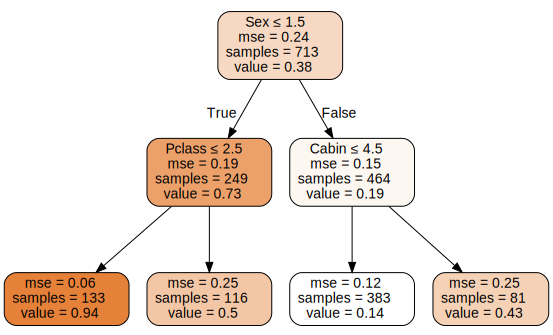

In [8]:
tree = DecisionTreeRegressor(max_leaf_nodes=4)
tree.fit(xs, y);
draw_tree(tree, xs, size=10, leaves_parallel=True, precision=2)

In [112]:
predictions = tree.predict(xs).astype(np.float32)
predictions.dtype

dtype('float32')

In [7]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [117]:
m_rmse(tree, xs_valid, y_valid)

0.367702

In [8]:
def rf(xs, y, n_estimators=20,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [166]:
forest = rf(xs, y)

In [167]:
m_rmse(forest, xs, y), m_rmse(forest, xs_valid, y_valid)

(0.366592, 0.527696)

In [9]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

<AxesSubplot:ylabel='cols'>

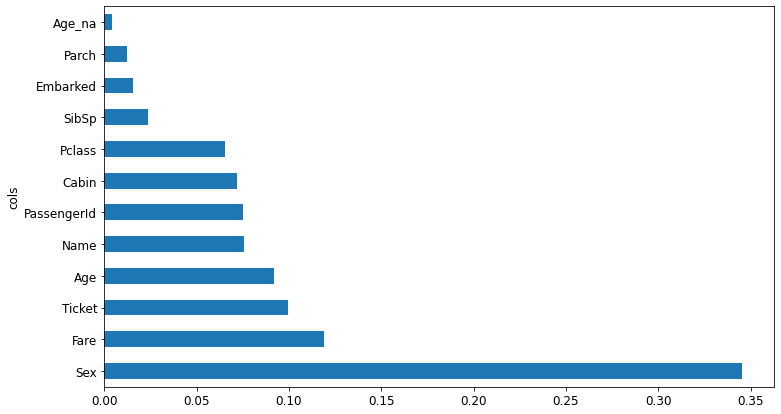

In [19]:
fi = rf_feat_importance(forest, xs)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [149]:
to_keep = fi[fi.imp>0.005].cols
to_keep

3             Sex
11           Fare
5           Cabin
1          Pclass
4          Ticket
8             Age
0     PassengerId
2            Name
9           SibSp
6        Embarked
Name: cols, dtype: object

In [150]:
xs = xs[to_keep]
xs_valid = xs_valid[to_keep]

In [14]:
forest = rf(xs, y)

In [15]:
m_rmse(forest, xs, y), m_rmse(forest, xs_valid, y_valid)

(0.275192, 0.353337)

In [17]:
r_mse(forest.oob_prediction_, y)

0.375723

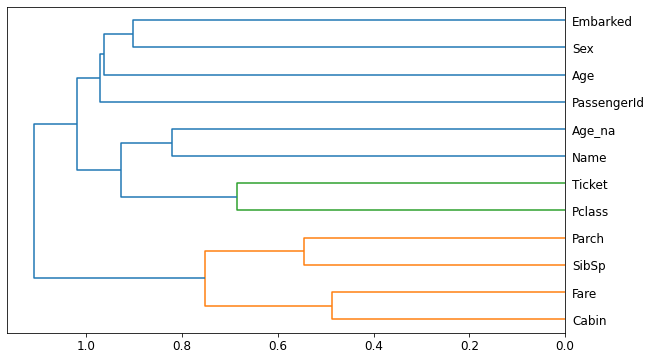

In [21]:
cluster_columns(xs)

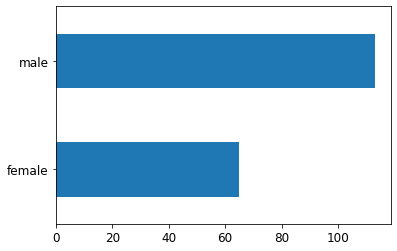

In [57]:
p = xs_valid['Sex'].value_counts(sort=False).plot.barh()
c = tabpanda.classes['Sex'][1:]
plt.yticks(range(len(c)), c);

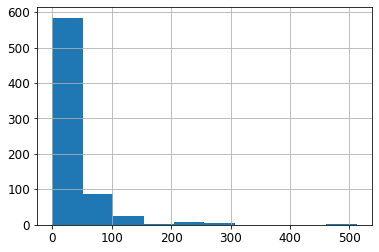

In [59]:
ax = xs['Fare'].hist()

In [32]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [33]:
row = xs_valid.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(tree, row.values)
prediction[0], bias[0] + contributions[0].sum()

(array([0.93984962]), 0.9398496240601504)

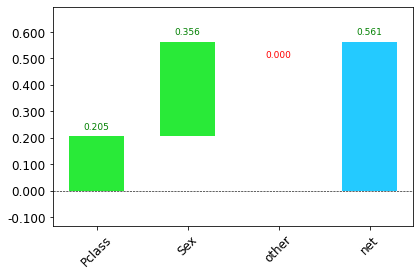

In [34]:
waterfall(xs_valid.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### NEURAL NET

In [265]:
df_nn = pd.read_csv(path/'train.csv', low_memory = False)
df_nn = df_nn.fillna(0)
df_nn['PassengerId'] = df_nn['PassengerId'].astype('category')
df_nn['Pclass'] = df_nn['Pclass'].astype('category')
df_nn['SibSp'] = df_nn['SibSp'].astype(np.float32)
df_nn['Parch'] = df_nn['Parch'].astype(np.float32)
df_nn['Survived'] = df_nn['Survived'].astype(np.float32)
continious, categorical = cont_cat_split(df_nn, 1, dep_var = 'Survived')
continious, categorical

(['Age', 'Fare'],
 ['PassengerId',
  'Pclass',
  'Name',
  'Sex',
  'SibSp',
  'Parch',
  'Ticket',
  'Cabin',
  'Embarked'])

In [266]:
df_nn[continious].dtypes, df_nn[categorical].dtypes

(Age     float64
 Fare    float64
 dtype: object,
 PassengerId    category
 Pclass         category
 Name             object
 Sex              object
 SibSp           float32
 Parch           float32
 Ticket           object
 Cabin            object
 Embarked         object
 dtype: object)

In [267]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, categorical, continious,
                        splits = RandomSplitter()(range_of(df)),
                        y_names='Survived'
                     )

In [268]:
xs_valid, y_valid = to_nn.valid.xs, to_nn.valid.y

In [269]:
dls = to_nn.dataloaders(64)

In [270]:
learn = tabular_learner(dls, y_range=(0,1), layers=[1024, 512], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=2.2908675418875646e-06)

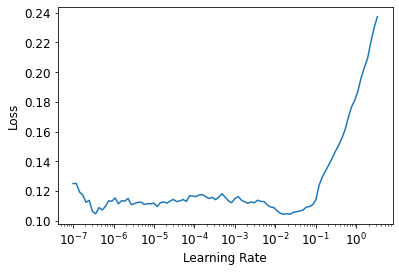

In [275]:
learn.lr_find()

In [274]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,0.132459,0.271888,00:00
1,0.123016,0.252192,00:00
2,0.120391,0.245919,00:00
3,0.115424,0.243718,00:00
4,0.116583,0.244091,00:00


In [276]:
preds,targs = learn.get_preds()
F.mse_loss(preds,targs)

tensor(0.2441)

In [277]:
df_test = pd.read_csv(path/'test.csv', low_memory = False)
df_test['PassengerId'] = df_test['PassengerId'].astype('category')
df_test['Pclass'] = df_test['Pclass'].astype('category')
df_test['SibSp'] = df_test['SibSp'].astype(np.float32)
df_test['Parch'] = df_test['Parch'].astype(np.float32)

In [284]:
len(df_test[pd.isnull(df_test['Age'])]['Age']), len(df_test)

(86, 418)

In [289]:
df_nn['Fare'].mean()

32.204207968574636

In [290]:
df_test.loc[pd.isnull(df_test['Fare']), 'Fare'] = 32

In [291]:
dl_test = learn.dls.test_dl(df_test)

In [256]:
dl_test = learn.dls.test_dl(df_nn)

In [310]:
predictions = learn.get_preds(dl=dl_test)

In [306]:
len(predictions)

2

In [311]:
predictions = torch.round(predictions[0])
predictions

tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [312]:
save_pickle(path/'results.pkl', predictions)

In [10]:
predictions = load_pickle(path/'results.pkl')

In [12]:
rdf = pd.DataFrame(pd.read_csv(path/'test.csv', low_memory = False)['PassengerId'])

In [13]:
rdf['Survived'] = predictions.int().squeeze().tolist()

In [14]:
predictions[0]

tensor([0.])

In [15]:
rdf

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [16]:
rdf.to_csv(path/'submission.csv', index=False)

In [6]:
rdf = pd.read_csv(path/'results_with_ids', low_memory = False)

In [7]:
rdf

,Unnamed: 0,PassengerId,Survived
0,0,892,0
1,1,893,1
2,2,894,0
3,3,895,0
4,4,896,1
...,...,...,...
413,413,1305,0
414,414,1306,1
415,415,1307,0
416,416,1308,0
